# Human Activity Recognition Using Smartphones Data Set

## `Introduction`

We will be using the [Human Activity Recognition with Smartphones](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) database, which was built from the recordings of study participants performing activities of daily living (ADL) while carrying a smartphone with an embedded inertial sensors. The objective is to classify activities into one of the six activities (walking, walking upstairs, walking downstairs, sitting, standing, and laying) performed.

For each record in the dataset it is provided: 

- Triaxial acceleration from the accelerometer (total acceleration) and the estimated body acceleration. 
- Triaxial Angular velocity from the gyroscope. 
- A 561-feature vector with time and frequency domain variables. 
- Its activity label. 

More information about the features is available on the website above.

## `Plan for data exploration`
1. Exploring data 
    * Examine the data types and value_counts
2. feature engineering 
    * see the data distribution
    * removing unimportant data if found 
    * dealing with missing (NaN) values if found
    * feature scalling for continuous variables if needed
3. encoding
    * encoding for categorical variables if found as to Encode the activity label as an integer
4. Spliting the Data
    * StratifiedShuffleSplit
5. Applying classification models
    * Logistic Regression
    * K-Nearest Neighbors (KNeighbors)
    * Decision Trees
    * Ensemble Methods (Gradient Boosting) 
6. Selecting the best model
7. Next steps

## `Exploring and feature engineering`

In [1]:
# importing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_predict, GridSearchCV, train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import Pipeline

%matplotlib inline

In [2]:
filepath = 'data/Human_Activity_Recognition_Using_Smartphones_Data.csv'
data = pd.read_csv(filepath, sep=',')
data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,STANDING


In [3]:
data.dtypes.value_counts()

float64    561
object       1
dtype: int64

The data columns are all floats except for the activity label.

In [4]:
# see the min and max of data excluding the target
print('min = ',data.iloc[:, :-1].min().value_counts())
print('max = ',data.iloc[:, :-1].max().value_counts())

min =  -1.0    561
dtype: int64
max =  1.0    561
dtype: int64


The data are all scaled from -1 (minimum) to 1.0 (maximum).

In [5]:
# Examine the breakdown of activities-- to see if balanced or not
data.Activity.value_counts(normalize=True)

LAYING                0.188756
STANDING              0.185067
SITTING               0.172541
WALKING               0.167201
WALKING_UPSTAIRS      0.149917
WALKING_DOWNSTAIRS    0.136518
Name: Activity, dtype: float64

In [6]:
data.isnull().sum().all()

False

## `encoding`

Scikit learn classifiers won't accept a sparse matrix for the prediction column. Thus, either `LabelEncoder` needs to be used to convert the activity labels to integers, or if `DictVectorizer` is used, the resulting matrix must be converted to a non-sparse array.  

we will use `LabelEncoder` to fit_transform the "Activity" column, and look at 5 random values.

In [7]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['Activity'] = le.fit_transform(data.Activity)
data['Activity'].sample(5)
### END SOLUTION

1015    2
4858    5
7820    2
727     1
9480    0
Name: Activity, dtype: int32

## `looking at correlation`

* Calculate the correlations between the dependent variables.
* Create a histogram of the correlation values
* Identify those that are most correlated (either positively or negatively).

In [8]:
# Calculate the correlation values
feature_cols = data.columns[:-1]
corr_values = data[feature_cols].corr()

# Simplify by emptying all the data below the diagonal
tril_index = np.tril_indices_from(corr_values)

# Make the unused values NaNs
for coord in zip(*tril_index):
    corr_values.iloc[coord[0], coord[1]] = np.NaN
    
# Stack the data and convert to a data frame
corr_values = (corr_values
               .stack()
               .to_frame()
               .reset_index()
               .rename(columns={'level_0':'feature1',
                                'level_1':'feature2',
                                0:'correlation'}))

# Get the absolute values for sorting
corr_values['abs_correlation'] = corr_values.correlation.abs()
corr_values

,feature1,feature2,correlation,abs_correlation
0,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,0.128037,0.128037
1,tBodyAcc-mean()-X,tBodyAcc-mean()-Z,-0.230302,0.230302
2,tBodyAcc-mean()-X,tBodyAcc-std()-X,0.004590,0.004590
3,tBodyAcc-mean()-X,tBodyAcc-std()-Y,-0.016785,0.016785
4,tBodyAcc-mean()-X,tBodyAcc-std()-Z,-0.036071,0.036071
...,...,...,...,...
157075,"angle(tBodyGyroJerkMean,gravityMean)","angle(Y,gravityMean)",-0.004582,0.004582
157076,"angle(tBodyGyroJerkMean,gravityMean)","angle(Z,gravityMean)",-0.012549,0.012549
157077,"angle(X,gravityMean)","angle(Y,gravityMean)",-0.748249,0.748249
157078,"angle(X,gravityMean)","angle(Z,gravityMean)",-0.635231,0.635231


In [9]:
# The most highly correlated values
corr_values.sort_values('correlation', ascending=False).query('abs_correlation>0.8')

,feature1,feature2,correlation,abs_correlation
156894,fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-sma(),1.000000,1.000000
93902,tBodyAccMag-sma(),tGravityAccMag-sma(),1.000000,1.000000
101139,tBodyAccJerkMag-mean(),tBodyAccJerkMag-sma(),1.000000,1.000000
96706,tGravityAccMag-mean(),tGravityAccMag-sma(),1.000000,1.000000
94257,tBodyAccMag-energy(),tGravityAccMag-energy(),1.000000,1.000000
...,...,...,...,...
22657,tGravityAcc-mean()-Y,"angle(Y,gravityMean)",-0.993425,0.993425
39225,"tGravityAcc-arCoeff()-Z,3","tGravityAcc-arCoeff()-Z,4",-0.994267,0.994267
38739,"tGravityAcc-arCoeff()-Z,2","tGravityAcc-arCoeff()-Z,3",-0.994628,0.994628
23176,tGravityAcc-mean()-Z,"angle(Z,gravityMean)",-0.994764,0.994764


## `Data split`

* This can be done using any method, but consider using Scikit-learn's `StratifiedShuffleSplit` to maintain the same ratio of predictor classes.


In [10]:
from sklearn.model_selection import StratifiedShuffleSplit
X = data[feature_cols]
y = data['Activity']

strat_shuf_split = StratifiedShuffleSplit(n_splits=1, 
                                          test_size=0.3, 
                                          random_state=42)

train_idx, test_idx = next(strat_shuf_split.split(X, y))
X_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, 'Activity']
X_test  = data.loc[test_idx, feature_cols]
y_test  = data.loc[test_idx, 'Activity']

In [11]:
y_train.value_counts(normalize=True)

0    0.188792
2    0.185046
1    0.172562
3    0.167152
5    0.149951
4    0.136496
Name: Activity, dtype: float64

In [12]:
y_test.value_counts(normalize=True)

0    0.188673
2    0.185113
1    0.172492
3    0.167314
5    0.149838
4    0.136570
Name: Activity, dtype: float64

we maintained the distribution of the target class seccussfuly

## `Applying classification models`

- Logistic Regression
- K-Nearest Neighbors (KNeighbors)
- Decision Trees
- Ensemble Methods (Gradient Boosting)

### `1.Logistic Regression`

In [13]:
from sklearn.linear_model import LogisticRegression
# Standard logistic regression
lr = LogisticRegression(solver='liblinear').fit(X_train, y_train)

In [14]:
from sklearn.linear_model import LogisticRegressionCV
# L1 regularized logistic regression
lr_l1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear').fit(X_train, y_train)
# L2 regularized logistic regression
lr_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='liblinear').fit(X_train, y_train)

* Predict and store the class for each model.
* Store the probability for the predicted class for each model. 

In [15]:
# Predict the class and the probability for each
y_pred = list()
y_prob = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    y_pred.append(pd.Series(mod.predict(X_test), name=lab))
    y_prob.append(pd.Series(mod.predict_proba(X_test).max(axis=1), name=lab))
    
y_pred = pd.concat(y_pred, axis=1)
y_prob = pd.concat(y_prob, axis=1)
y_pred.head()

,lr,l1,l2
0,3,3,3
1,5,5,5
2,3,3,3
3,1,1,1
4,0,0,0


In [16]:
y_prob.head()

,lr,l1,l2
0,0.998939,0.998948,0.999998
1,0.988165,0.999674,0.999477
2,0.987592,0.996099,0.999697
3,0.981381,0.999179,0.999865
4,0.998277,0.999920,0.999997


#### `error metrics`

For each model, calculate the following error metrics: 
* Accuracy
* Precision
* Recall
* F-score
* Confusion Matrix

In [17]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

metrics = list()
cm = dict()

for lab in coeff_labels:

    precision, recall, fscore, _ = score(y_test, y_pred[lab], average='weighted')
    
    accuracy = accuracy_score(y_test, y_pred[lab])
    
    # ROC-AUC scores can be calculated by binarizing the data
    auc = roc_auc_score(label_binarize(y_test, classes=[0,1,2,3,4,5]),
              label_binarize(y_pred[lab], classes=[0,1,2,3,4,5]), 
              average='weighted')
    
    cm[lab] = confusion_matrix(y_test, y_pred[lab])
    
    metrics.append(pd.Series({'precision':precision, 'recall':recall, 
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc':auc}, 
                             name=lab))

metrics = pd.concat(metrics, axis=1)

In [18]:
metrics

,lr,l1,l2
precision,0.984144,0.983514,0.984477
recall,0.984142,0.983495,0.984466
fscore,0.984143,0.983492,0.984464
accuracy,0.984142,0.983495,0.984466
auc,0.990384,0.989949,0.990553


In [19]:
from sklearn.metrics import f1_score

lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
f1_lr = f1_score(y_pred, y_test, average='weighted')
f1_lr

0.9841419612283467

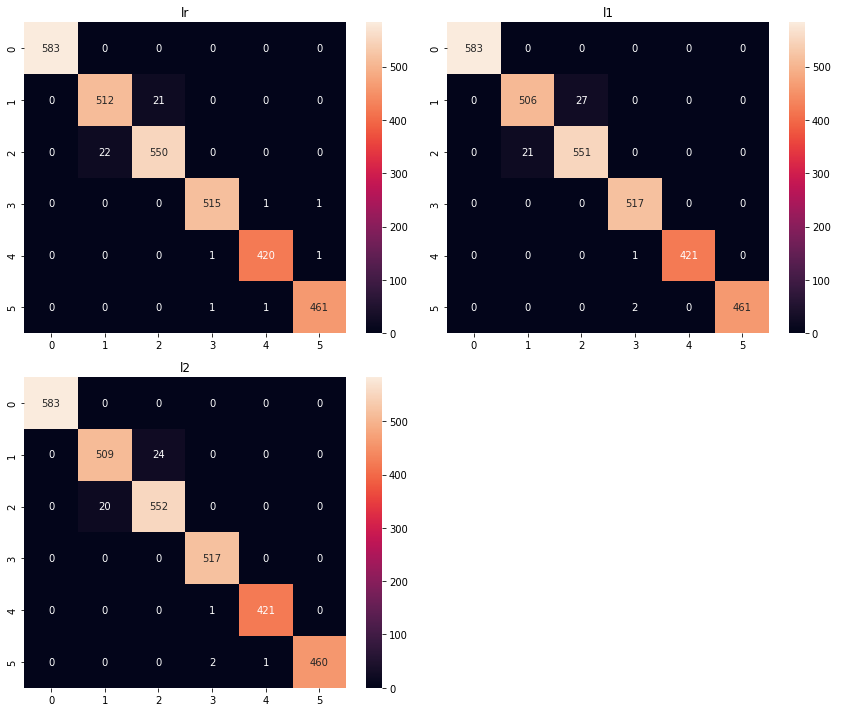

In [20]:
### Display or plot the confusion matrix for each model.

fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)

axList[-1].axis('off')

for ax,lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm[lab], ax=ax, annot=True, fmt='d');
    ax.set(title=lab);
    
plt.tight_layout()

### `2.K-Nearest Neighbors (KNeighbors)`

In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score

knn = KNeighborsClassifier(n_neighbors=3, weights='distance')
knn = knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
f1_knn = f1_score(y_pred, y_test, average='weighted')
f1_knn

0.9679843882037947

### `3.Decision Trees`

In [22]:
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings("ignore")

tuning_parameters = {'max_depth':[2,4,6,8,10],
                     'min_samples_leaf':[2,4,6,8,10], 
                     'min_samples_split':[2,4,6,8,10]}

scorer = make_scorer(f1_score, average = 'weighted')
GR = GridSearchCV(DecisionTreeClassifier(random_state=42), tuning_parameters, scoring=scorer,)
GR = GR.fit(X_train, y_train)

print('GR.best_estimator_: ', GR.best_estimator_)
print('GR.best_score_: ', GR.best_score_)
print('GR.best_params_: ', GR.best_params_)

GR.best_estimator_:  DecisionTreeClassifier(max_depth=10, min_samples_leaf=4, min_samples_split=10,
                       random_state=42)
GR.best_score_:  0.9266884691991407
GR.best_params_:  {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}


In [27]:
GR.best_score_, GR.best_params_

(0.9266884691991407,
 {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10})

In [30]:
y_pred = GR.predict(X_test)
f1_dt = f1_score(y_pred, y_test, average='weighted')
f1_dt

0.9276476807305897

### `4.GradientBoosting`

In [31]:
from sklearn.ensemble import GradientBoostingClassifier
GBC = GradientBoostingClassifier(max_features=5, n_estimators=100, random_state=42)
GBC.fit(X_train.values, y_train.values)
y_pred = GBC.predict(X_test)
f1_GBC = f1_score(y_pred, y_test, average='weighted')
f1_GBC

0.9805798565748332

## `Selecting best model`

In [32]:
pd.DataFrame({'Logistic Regression':f1_lr, 'KNN':f1_knn, 
                              'Decision Trees':f1_dt, 'Gradient Boosting':f1_GBC},index = ['F1_SCORE'])

,Logistic Regression,KNN,Decision Trees,Gradient Boosting
F1_SCORE,0.984142,0.967984,0.927648,0.98058


#### so we will chooce `GradientBoostingClassifier` or `logistic regression`

## `key findings`

logistic regression without regularization got us the highest F1_Score so we will choose it and Decision Trees took too long and got the worst score

## `Next steps`

we can use another encoding method like `LabelBinarizer` and we can try another ensemble method like `Random forest`